In [1]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np

# visualization libraries
from PIL import Image
from keras.utils import plot_model
from IPython.display import Image 

# preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# modelling
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import utils
from keras import optimizers
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam
from keras.applications.vgg19 import VGG19
from keras import losses
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
import math 

# callbacks
from keras.callbacks import History


# Surpress warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Importing & Exploring Data

In [2]:
new_dir = 'chest_xray/'

In [3]:
train_folder = os.path.join(new_dir, 'train')
test_folder = os.path.join(new_dir, 'test')
val_folder = os.path.join(new_dir, 'val')

In [4]:
# get all the data in the directory /train and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 624) 

# get all the data in the directory /val and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 16)

# get all the data in the directory /train and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [5]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

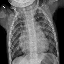

In [6]:
#preview training image
array_to_img(train_images[10])

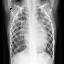

In [7]:
#preview training image
array_to_img(train_images[100])

In [8]:
# get shape of images in train and test

print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))


(5216, 64, 64, 3)
(5216, 2)
(624, 64, 64, 3)
(624, 2)


All images share the same dimensions, so we don't have to worry about losing any additional information by transforming and resizing the images to fit. We can go directly into refitting the test and training images from tensors to a single vectors for training, test, and validation purposes.

In [9]:
# reshape images to contain dimensions into a single vector
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 12288)
(624, 12288)
(16, 12288)


In [10]:
# reshape images to contain dimensions into a single vector
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [11]:
# train_img_unrow = train_images.reshape(4103, -1).T

In [12]:
# np.shape(train_img_unrow)

In [13]:
#m = 624
#test_img_unrow = test_images.reshape(624, -1).T

In [14]:
#np.shape(test_img_unrow)

Now that we've cleaned the data and reshaped the dimensions to fit into individual vectors, we can move on to identifying the existing labels for your test and training images. Ideally, we'll find a binary classification that classified images as "Normal"or as "Pneumonia". If any other labels exists, we can examine the data.

If a third label exists, we will further examine whether or not those labels include pneumonial examples that work for the purposes of this model.

In [15]:
#preview label to identify class valujes
train_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [16]:
#identify the categorical values of 0 and 1
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [17]:
train_labels_final = train_labels.T[[1]]
np.shape(train_labels_final)

(1, 5216)

In [18]:
test_labels_final = test_labels.T[[1]]
np.shape(test_labels_final)


(1, 624)

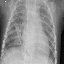

In [19]:
array_to_img(train_images[135])


In [20]:
train_labels_final[:,135]

array([1.], dtype=float32)

Recap: We've now idenitified our two categories: Normal and Pneumonia, represented by 0 and 1, respectively. Our images were successfully resized and ready to go through our base model. We double checked that all of our training and testing images fit the our categorical labels and there's no extraneous categories that might skew the model results.

## Base Model

In [21]:
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(12288,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer= 'sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                122890    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 102us/step - loss: 0.6441 - acc: 0.7395 - val_loss: 0.8350 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 0s 80us/step - loss: 0.4318 - acc: 0.7429 - val_loss: 0.8060 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 0s 76us/step - loss: 0.3377 - acc: 0.7429 - val_loss: 0.6099 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 0s 77us/step - loss: 0.2982 - acc: 0.8378 - val_loss: 0.5824 - val_acc: 0.8125
Epoch 5/30
5216/5216 [==============================] - 0s 74us/step - loss: 0.2774 - acc: 0.9176 - val_loss: 0.6148 - val_acc: 0.7500
Epoch 6/30
5216/5216 [==============================] - 0s 74us/step - loss: 0.2563 - acc: 0.9247 - val_loss: 0.5760 - val_acc: 0.8125
Epoch 7/30
5216/5216 [==============================] - 0s 67us/step - loss: 0.2315 - acc: 0.9363 - val_loss: 0.4136 - val_acc: 0.9375
Epoch 8/

In [23]:
results_train = model.evaluate(train_img, train_y)

5216/5216 [==============================] - 0s 44us/step


In [24]:
results_test = model.evaluate(test_img, test_y)

624/624 [==============================] - 0s 55us/step


In [25]:
results_train

[0.11905325001871293, 0.9620398773006135]

In [26]:
results_test

[1.110149363676707, 0.7259615384615384]

In [27]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

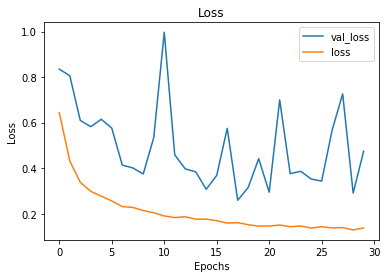

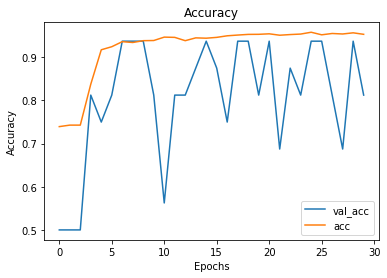

In [28]:
visualize_training_results(history)

Our first model showed 96% accuracy with .11 loss value for our training data, with minimal improvement after 10 epochs. However, when passing through our test data, the model's accuracy is considerable reduced at ~73% with considerably higher loss at 1.11.

The visualizations show that the test data exhibited the largest drops in accuracy and highest rates of error at 10 epoch in comparison to the training data where accurate and loss seemed to be the most optimized at 10 epochs. The test data shows a more drsstic change in accuracy and loss across.

We'll repeat this test by adding a hidden layer to see if we can improve the results

In [29]:
# repeat model test with hidden

np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(12288,)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# opt = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer= 'sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                122890    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 122,951
Trainable params: 122,951
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 0s 92us/step - loss: 0.4636 - acc: 0.7845 - val_loss: 0.5959 - val_acc: 0.7500
Epoch 2/30
5216/5216 [==============================] - 0s 70us/step - loss: 0.3015 - acc: 0.8729 - val_loss: 0.6835 - val_acc: 0.6875
Epoch 3/30
5216/5216 [==============================] - 0s 75us/step - loss: 0.2204 - acc: 0.9120 - val_loss: 0.3829 - val_acc: 0.8750
Epoch 4/30
5216/5216 [==============================] - 0s 74us/step - loss: 0.2156 - acc: 0.9126 - val_loss: 0.3504 - val_acc: 0.8750
Epoch 5/30
5216/5216 [==============================] - 0s 76us/step - loss: 0.1884 - acc: 0.9250 - val_loss: 0.3526 - val_acc: 0.8750
Epoch 6/30
5216/5216 [==============================] - 0s 72us/step - loss: 0.1868 - acc: 0.9266 - val_loss: 0.3558 - val_acc: 0.8125
Epoch 7/30
5216/5216 [==============================] - 0s 73us/step - loss: 0.1693 - acc: 0.9340 - val_loss: 0.3501 - val_acc: 0.8125
Epoch 8/3

In [31]:
results_train = model.evaluate(train_img, train_y)

5216/5216 [==============================] - 0s 45us/step


In [32]:
results_test = model.evaluate(test_img, test_y)

624/624 [==============================] - 0s 50us/step


In [33]:
results_train

[0.08872519832024453, 0.9674079754601227]

In [34]:
results_test

[0.8241774883025732, 0.7660256410256411]

Our first model showed 96% accuracy with .11 loss value for our training data, with minimal improvement after 10 epochs. However, when passing through our test data, the model's accuracy is considerable reduced at ~73% with considerably higher loss at 1.11.

The visualizations show that the test data exhibited the largest drops in accuracy and highest rates of error at 10 epoch in comparison to the training data where accurate and loss seemed to be the most optimized at 10 epochs. The test data shows a more drsstic change in accuracy and loss across.

We'll repeat this test by adding a hidden layer to see if we can improve the results

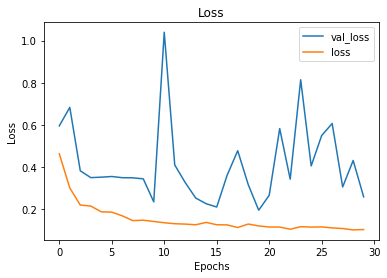

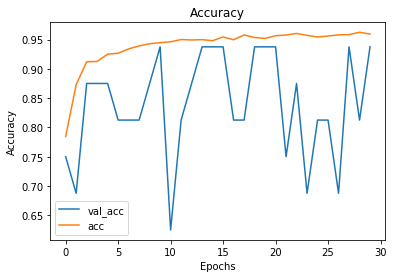

In [35]:
visualize_training_results(history)

We saw some improvement with our our second model. While the accuracy of our training model remain around the same, we saw reduced loss at .088.

We also saw some improvement for your test results, with loss decreasing to .824 (down from 1.11) and an increase in accuracy, from ~73% to ~77% accuracy.

Our visualizations closely mirror the visualizations of our previous model. It's possible that our network is too small for more consistent results as the model runs, so we'll try again with a larger network. Since was saw improvements in accuracy and loss after adding a hidden layer, we'll included a hidden layer in the larger network, as well.

In [36]:
# increase size of network
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(12288,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# opt = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer= 'sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                786496    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 788,609
Trainable params: 788,609
Non-trainable params: 0
_________________________________________________________________


In [37]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [38]:
history = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 213us/step - loss: 0.4648 - acc: 0.7868 - val_loss: 0.5159 - val_acc: 0.8125
Epoch 2/30
5216/5216 [==============================] - 1s 193us/step - loss: 0.2933 - acc: 0.8765 - val_loss: 0.6295 - val_acc: 0.6875
Epoch 3/30
5216/5216 [==============================] - 1s 196us/step - loss: 0.2121 - acc: 0.9155 - val_loss: 0.3473 - val_acc: 0.8750
Epoch 4/30
5216/5216 [==============================] - 1s 197us/step - loss: 0.2130 - acc: 0.9151 - val_loss: 0.3242 - val_acc: 0.8750
Epoch 5/30
5216/5216 [==============================] - 1s 199us/step - loss: 0.1875 - acc: 0.9268 - val_loss: 0.3310 - val_acc: 0.8750
Epoch 6/30
5216/5216 [==============================] - 1s 199us/step - loss: 0.1817 - acc: 0.9260 - val_loss: 0.2803 - val_acc: 0.9375
Epoch 7/30
5216/5216 [==============================] - 1s 206us/step - loss: 0.1673 - acc: 0.9346 - val_loss: 0.3511 - val_acc: 0.8750
Ep

In [39]:
results_train = model.evaluate(train_img, train_y)

5216/5216 [==============================] - 0s 88us/step


In [40]:
results_test = model.evaluate(test_img, test_y)

624/624 [==============================] - 0s 97us/step


In [41]:
results_train

[0.08882379600423977, 0.9668328220858896]

In [42]:
results_test

[0.7982656084574186, 0.780448717948718]

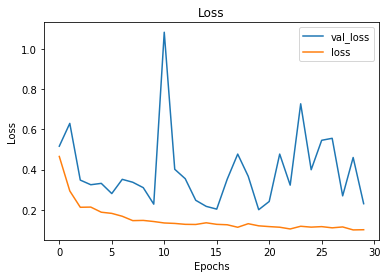

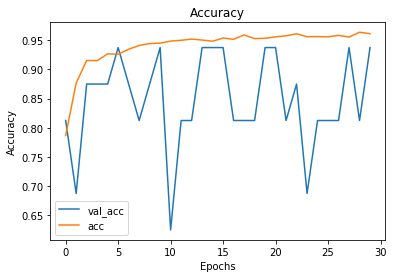

In [43]:
visualize_training_results(history)

With a larger network, our training model results showed little to no change, though we saw a 2% increase in accuracy for your testing model. However, we the drops in accuracy and increase in loss remains consistent. We can also see that our testing accuracy constantly plateaus at ~93% with and without the hidden layer.

The base models seem to have plateaued, so we'll try models with regulizers to see if we have any changes in our final testing results.

## Model with Regulizers

In [44]:
# run initial model with with hidden layer & regulizer
from keras import regularizers
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(12288,)))
model.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(12288,)))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                122890    
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 122,951
Trainable params: 122,951
Non-trainable params: 0
_________________________________________________________________


In [45]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [46]:
history = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_img, val_y))


Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 118us/step - loss: 0.4908 - acc: 0.7847 - val_loss: 0.6233 - val_acc: 0.7500
Epoch 2/30
5216/5216 [==============================] - 0s 84us/step - loss: 0.3286 - acc: 0.8750 - val_loss: 0.7104 - val_acc: 0.6875
Epoch 3/30
5216/5216 [==============================] - 0s 83us/step - loss: 0.2473 - acc: 0.9135 - val_loss: 0.4079 - val_acc: 0.8750
Epoch 4/30
5216/5216 [==============================] - 0s 85us/step - loss: 0.2454 - acc: 0.9122 - val_loss: 0.3811 - val_acc: 0.8750
Epoch 5/30
5216/5216 [==============================] - 0s 84us/step - loss: 0.2181 - acc: 0.9241 - val_loss: 0.3799 - val_acc: 0.8750
Epoch 6/30
5216/5216 [==============================] - 0s 85us/step - loss: 0.2176 - acc: 0.9252 - val_loss: 0.3872 - val_acc: 0.8125
Epoch 7/30
5216/5216 [==============================] - 1s 100us/step - loss: 0.1988 - acc: 0.9342 - val_loss: 0.3765 - val_acc: 0.8125
Epoch 8

In [47]:
results_train = model.evaluate(train_img, train_y)

5216/5216 [==============================] - 0s 50us/step


In [48]:
results_test = model.evaluate(test_img, test_y)

624/624 [==============================] - 0s 46us/step


In [49]:
results_train

[0.11734487143762272, 0.9672162576687117]

In [50]:
results_test

[0.83641139513407, 0.7644230769230769]

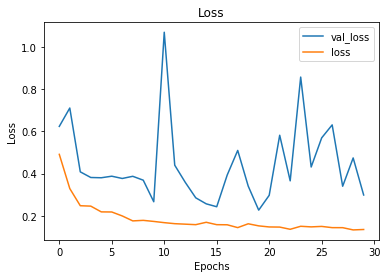

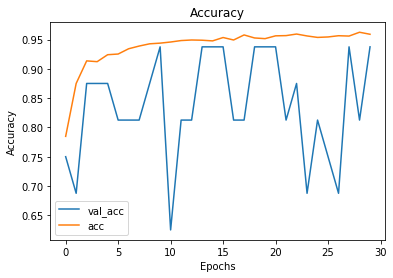

In [51]:
visualize_training_results(history)

Even with regularizers, our results are near identical to our previous models. We'll try again with a bigger network to see if our model still shows minimal change.

In [52]:
# run initial model with with hidden layer & regulizer
from keras import regularizers
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(12288,)))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(12288,)))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                786496    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 788,609
Trainable params: 788,609
Non-trainable params: 0
_________________________________________________________________


In [53]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [54]:
history = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_img, val_y))


Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 2s 331us/step - loss: 0.6415 - acc: 0.7834 - val_loss: 0.6590 - val_acc: 0.8125
Epoch 2/30
5216/5216 [==============================] - 1s 283us/step - loss: 0.4700 - acc: 0.8748 - val_loss: 0.7959 - val_acc: 0.6875
Epoch 3/30
5216/5216 [==============================] - 2s 291us/step - loss: 0.3898 - acc: 0.9116 - val_loss: 0.5136 - val_acc: 0.8750
Epoch 4/30
5216/5216 [==============================] - 2s 294us/step - loss: 0.3830 - acc: 0.9147 - val_loss: 0.5083 - val_acc: 0.8750
Epoch 5/30
5216/5216 [==============================] - 1s 286us/step - loss: 0.3546 - acc: 0.9283 - val_loss: 0.4765 - val_acc: 0.8750
Epoch 6/30
5216/5216 [==============================] - 2s 293us/step - loss: 0.3553 - acc: 0.9239 - val_loss: 0.4662 - val_acc: 0.9375
Epoch 7/30
5216/5216 [==============================] - 2s 293us/step - loss: 0.3357 - acc: 0.9348 - val_loss: 0.5221 - val_acc: 0.8750
Ep

In [55]:
results_train = model.evaluate(train_img, train_y)

5216/5216 [==============================] - 1s 112us/step


In [56]:
results_test = model.evaluate(test_img, test_y)

624/624 [==============================] - 0s 120us/step


In [57]:
results_train

[0.2336711039755242, 0.9677914110429447]

In [58]:
results_test

[0.9612838671757624, 0.7724358974358975]

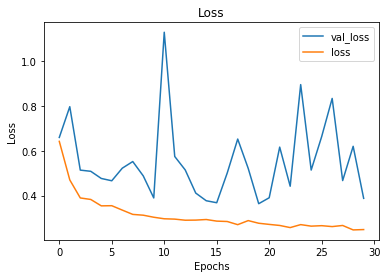

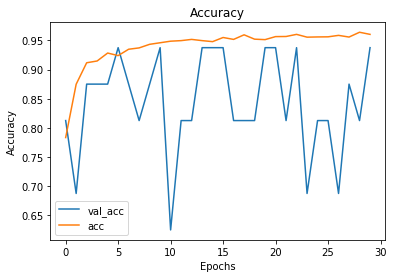

In [59]:
visualize_training_results(history)

With regulizers, our larger network performed the same, if not a bit worse, than when we ran the model without regulizers. Since we've seen so little improvement, we'll try again. This time we'll use a CNN o see if the pre-processing helps improve the model's accuracy.

## CNN Model

In [60]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

In [61]:
history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 20s 4ms/step - loss: 0.5717 - acc: 0.7429 - val_loss: 0.8791 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 20s 4ms/step - loss: 0.5243 - acc: 0.7444 - val_loss: 0.9496 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 20s 4ms/step - loss: 0.4475 - acc: 0.7937 - val_loss: 0.6044 - val_acc: 0.6250
Epoch 4/30
5216/5216 [==============================] - 20s 4ms/step - loss: 0.3333 - acc: 0.8556 - val_loss: 1.0460 - val_acc: 0.5625
Epoch 5/30
5216/5216 [==============================] - 20s 4ms/step - loss: 0.2471 - acc: 0.8995 - val_loss: 0.5227 - val_acc: 0.7500
Epoch 6/30
5216/5216 [==============================] - 20s 4ms/step - loss: 0.2088 - acc: 0.9153 - val_loss: 0.4620 - val_acc: 0.7500
Epoch 7/30
5216/5216 [==============================] - 20s 4ms/step - loss: 0.1783 - acc: 0.9271 - val_loss: 0.8497 - val_acc: 0.5625
Epoch 8/3

In [62]:
results_train = model.evaluate(train_images, train_y)

5216/5216 [==============================] - 5s 966us/step


In [63]:
results_test = model.evaluate(test_images, test_y)

624/624 [==============================] - 1s 1ms/step


In [64]:
results_train

[0.058695626487966876, 0.9806365030674846]

In [65]:
results_test

[0.8354575358904325, 0.7708333333333334]

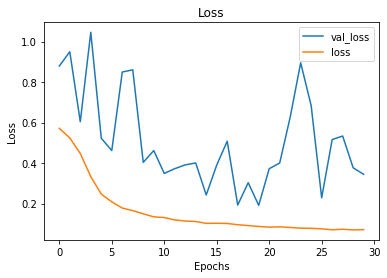

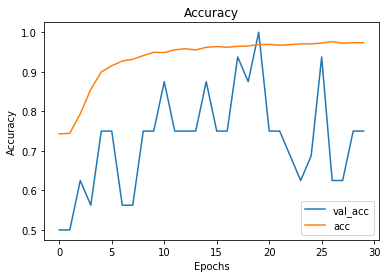

In [66]:
visualize_training_results(history)

We saw an increase in accuracy in our training results, now with a 98% accuracy and .058 loss, but we saw no change in our test results. Judging by our visualizations, however, we did see that our model more gradually improved at testing went on (up to 20 epochs), in comparison to our previous models. Instead of sharp increases and maximum plateaus, we saw more gradual increases with plateaus in accuracy occuring in decreases of accuracy verus increases.

## Conclusion

Through all of our models, we saw minimum increases in test models, even though we did maintain a 4-6% increase in accuracy outside of our base model. While the results didn't change much, the visualizations did give us some insight on what happened in the model. Each of the non-CNN models hit a repeated ceiling in accuracy where the results plateaued for a few epochs befor a signfinicant drop, mirrored by a sigificant increase in error rate. The CNN model showed more gradual increases in the testing model results, versus the steep increases in accuracy followed by a plateau and steep drops we saw earlier.

Whether or not this accuracy plateau was due to the data quality, sample sizes, or issues in how the models were created is unknown. Trying additional CNN methods might help address this issue so we can produce more accurate results